In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("/content/ai_hiring_assignment_dataset.csv")

In [3]:
df.head()

,candidate_skills,years_experience,education_level,past_job_titles,certifications,expected_salary,candidate_location,job_title,required_skills,min_experience,job_description,budgeted_salary_min,budgeted_salary_max,job_location,is_fit
0,"Node.js, AWS, Python, SQL, NLP, Deep Learning",6,High School,"Backend Engineer, Software Developer",Google ML Certificate,129409,New York,AI Researcher,"Data Analysis, Deep Learning, React, Docker, Java",0,Looking for a motivated individual with strong...,81174,141383,Remote,0
1,"TensorFlow, React, Machine Learning",2,Master's,ML Engineer,Coursera NLP,113724,Austin,Backend Engineer,"Deep Learning, Pandas, Data Analysis, Java, NLP",1,Looking for a motivated individual with strong...,64098,115875,Remote,0
2,"Kubernetes, Python, Pandas, AWS",11,High School,"Backend Engineer, ML Engineer","AWS Certified, Coursera NLP",67692,New York,AI Researcher,"SQL, React, Java, Kubernetes, TensorFlow",6,Looking for a motivated individual with strong...,76658,105418,San Francisco,0
3,"TensorFlow, Pandas, Java",7,Master's,Backend Engineer,"AWS Certified, DataCamp DS",52242,Seattle,Backend Engineer,"Deep Learning, Machine Learning, Docker",0,Looking for a motivated individual with strong...,68814,132259,Austin,0
4,"Python, React, Docker, SQL, Data Analysis, Dee...",12,Bachelor's,Software Developer,"Coursera NLP, None",120550,Remote,ML Engineer,"Pandas, Kubernetes, Data Analysis, React, NLP",9,Looking for a motivated individual with strong...,65110,141471,Remote,1


In [4]:
df.shape

(5000, 15)

In [5]:
df.columns

Index(['candidate_skills', 'years_experience', 'education_level',
       'past_job_titles', 'certifications', 'expected_salary',
       'candidate_location', 'job_title', 'required_skills', 'min_experience',
       'job_description', 'budgeted_salary_min', 'budgeted_salary_max',
       'job_location', 'is_fit'],
      dtype='object')

In [6]:
df["job_title"].nunique()

5

In [7]:
df.isnull().sum()

,0
candidate_skills,0
years_experience,0
education_level,0
past_job_titles,0
certifications,525
expected_salary,0
candidate_location,0
job_title,0
required_skills,0
min_experience,0


Handling null values, certification col..

In [8]:
df['certifications'] = df['certifications'].fillna('No Certifications')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   candidate_skills     5000 non-null   object
 1   years_experience     5000 non-null   int64 
 2   education_level      5000 non-null   object
 3   past_job_titles      5000 non-null   object
 4   certifications       5000 non-null   object
 5   expected_salary      5000 non-null   int64 
 6   candidate_location   5000 non-null   object
 7   job_title            5000 non-null   object
 8   required_skills      5000 non-null   object
 9   min_experience       5000 non-null   int64 
 10  job_description      5000 non-null   object
 11  budgeted_salary_min  5000 non-null   int64 
 12  budgeted_salary_max  5000 non-null   int64 
 13  job_location         5000 non-null   object
 14  is_fit               5000 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 586.1+ KB


 Feature engineering..

In [10]:
def preprocess_skills(text):
  return set(map(str.strip, text.lower().split(',')))

In [11]:
df[['candidate_skills_set', 'required_skills_set']] = df[['candidate_skills', 'required_skills']].applymap(preprocess_skills)

/tmp/ipython-input-11-4033204910.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['candidate_skills_set', 'required_skills_set']] = df[['candidate_skills', 'required_skills']].applymap(preprocess_skills)


In [12]:
df[['candidate_skills_set', 'required_skills_set']]

,candidate_skills_set,required_skills_set
0,"{sql, nlp, node.js, deep learning, aws, python}","{java, docker, deep learning, react, data anal..."
1,"{tensorflow, react, machine learning}","{java, nlp, deep learning, pandas, data analysis}"
2,"{aws, python, pandas, kubernetes}","{tensorflow, java, sql, react, kubernetes}"
3,"{tensorflow, java, pandas}","{deep learning, docker, machine learning}"
4,"{sql, data analysis, docker, deep learning, re...","{nlp, pandas, react, data analysis, kubernetes}"
...,...,...
4995,"{java, deep learning, pandas, react, data anal...","{deep learning, sql, kubernetes, docker}"
4996,"{java, nlp, deep learning, pandas, python, kub...","{deep learning, data analysis, sql}"
4997,"{java, sql, pandas, react, python}","{nlp, data analysis, kubernetes, docker}"
4998,"{tensorflow, sql, machine learning, nlp, data ...","{java, data analysis, pandas, aws}"


In [13]:
df['skill_match'] = df.apply(lambda x: len(x['candidate_skills_set'] & x['required_skills_set']) / max(len(x['required_skills_set']), 1), axis=1)

In [14]:
df['skill_match'].head()

,skill_match
0,0.2
1,0.0
2,0.2
3,0.0
4,0.4


In [15]:
df['experience_diff'] = df['years_experience'] - df['min_experience']

In [16]:
df['experience_diff'].head()

,experience_diff
0,6
1,1
2,5
3,7
4,3


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   candidate_skills      5000 non-null   object 
 1   years_experience      5000 non-null   int64  
 2   education_level       5000 non-null   object 
 3   past_job_titles       5000 non-null   object 
 4   certifications        5000 non-null   object 
 5   expected_salary       5000 non-null   int64  
 6   candidate_location    5000 non-null   object 
 7   job_title             5000 non-null   object 
 8   required_skills       5000 non-null   object 
 9   min_experience        5000 non-null   int64  
 10  job_description       5000 non-null   object 
 11  budgeted_salary_min   5000 non-null   int64  
 12  budgeted_salary_max   5000 non-null   int64  
 13  job_location          5000 non-null   object 
 14  is_fit                5000 non-null   int64  
 15  candidate_skills_set 

In [18]:
# salary features..
df['salary_within_range'] = df.apply(lambda x: 1 if x['budgeted_salary_min'] <= x['expected_salary'] <= x['budgeted_salary_max'] else 0, axis=1)

In [19]:
df['salary_diff'] = abs(df['expected_salary'] - (df['budgeted_salary_min'] + df['budgeted_salary_max']) / 2)

In [20]:
# location match..
df['location_match'] = (df['candidate_location'].str.lower() == df['job_location'].str.lower()).astype(int)

In [21]:
edu_encode = {'High School': 0, "Bachelor's": 1, "Master's": 2, 'PhD': 3}
df['education_level_encoded'] = df['education_level'].map(edu_encode)

In [22]:
# drop unused columns..
df.drop(columns=['candidate_skills_set', 'required_skills_set'], inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   candidate_skills         5000 non-null   object 
 1   years_experience         5000 non-null   int64  
 2   education_level          5000 non-null   object 
 3   past_job_titles          5000 non-null   object 
 4   certifications           5000 non-null   object 
 5   expected_salary          5000 non-null   int64  
 6   candidate_location       5000 non-null   object 
 7   job_title                5000 non-null   object 
 8   required_skills          5000 non-null   object 
 9   min_experience           5000 non-null   int64  
 10  job_description          5000 non-null   object 
 11  budgeted_salary_min      5000 non-null   int64  
 12  budgeted_salary_max      5000 non-null   int64  
 13  job_location             5000 non-null   object 
 14  is_fit                  

In [24]:
df["education_level"].nunique()

4

prepare target features col..

In [25]:
features = ['skill_match', 'experience_diff', 'salary_within_range', 'salary_diff', 'location_match', 'education_level_encoded']
X = df[features]
y = df['is_fit']

Train, Test split data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# XGBoost model..


In [27]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Results:\n", classification_report(y_test, xgb_preds))

XGBoost Results:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       961
           1       0.79      0.67      0.72        39

    accuracy                           0.98      1000
   macro avg       0.89      0.83      0.86      1000
weighted avg       0.98      0.98      0.98      1000



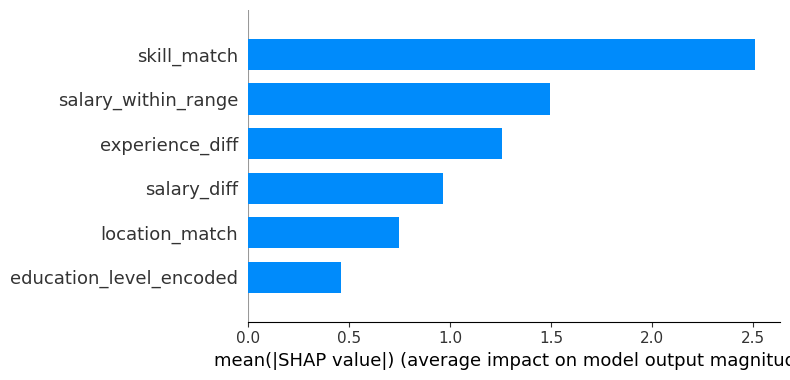

In [28]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Logistic Regression model..

In [29]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [30]:
def build_candidate_summary(row):
    return (
        f"Candidate has {row['years_experience']} years of experience, "
        f"has held job titles such as {row['past_job_titles']}, "
        f"has skills: {row['candidate_skills']}, "
        f"expects a salary of {row['expected_salary']}, "
        f"is located in {row['candidate_location']}, "
        f"and has an education level of {row['education_level']}."
    )

In [31]:
df['candidate_summary'] = df.apply(build_candidate_summary, axis=1)

In [32]:
def combine_text(row):
    return f"Job: {row['job_description']} Candidate: {row['candidate_summary']}"

In [33]:
df['combined_text'] = df.apply(combine_text, axis=1)

In [34]:
embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True)
X_emb = np.array(embeddings)
y_emb = df['is_fit']

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y_emb, stratify=y_emb, test_size=0.2, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_emb, y_train_emb)

y_pred_emb = clf.predict(X_test_emb)
print("Logistic Regression:\n", classification_report(y_test_emb, y_pred_emb))

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       961
           1       0.00      0.00      0.00        39

    accuracy                           0.96      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.92      0.96      0.94      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Random Forest..

In [36]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Results:\n", classification_report(y_test, rf_preds))

Random Forest Results:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       961
           1       0.93      0.67      0.78        39

    accuracy                           0.98      1000
   macro avg       0.96      0.83      0.88      1000
weighted avg       0.98      0.98      0.98      1000



In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   candidate_skills         5000 non-null   object 
 1   years_experience         5000 non-null   int64  
 2   education_level          5000 non-null   object 
 3   past_job_titles          5000 non-null   object 
 4   certifications           5000 non-null   object 
 5   expected_salary          5000 non-null   int64  
 6   candidate_location       5000 non-null   object 
 7   job_title                5000 non-null   object 
 8   required_skills          5000 non-null   object 
 9   min_experience           5000 non-null   int64  
 10  job_description          5000 non-null   object 
 11  budgeted_salary_min      5000 non-null   int64  
 12  budgeted_salary_max      5000 non-null   int64  
 13  job_location             5000 non-null   object 
 14  is_fit                  